In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
def get_normalized_data():
    print("Reading in and transforming data...")
    
    
    df = pd.read_csv('C:/Users/TANNERU/Downloads/train.csv/train.csv')
    #print(df)
    data = df.values.astype(np.float32)
    #print(data)
    
    np.random.shuffle(data)
    
    
    X = data[:,1:] #except 1 columns
    Y = data[:,0].astype(np.int32) #only 1st column
    print("Innputs",X)
    print("output",Y)
    print(X.shape) #(42000, 784)
    print(Y.shape) #(42000,)
    
    
    Xtrain = X[:-1000]
    Xtest = X[-1000:]
    Ytrain = Y[:-1000]
    Ytest = Y[-1000:]
    print("Xtrain",Xtrain.shape)#(41000, 784)
    print("Xtest",Xtest.shape)#(1000, 784)
    print("Ytrain",Ytrain.shape)#(41000,)
    print("Ytest",Ytest.shape) #(1000,)
    
    
    mu = Xtrain.mean(axis = 0) #(784,)
    std = Xtrain.std(axis = 0) 
    np.place(std,std == 0,1) # changes all values to 0,1
    print(np.place(std,std == 0,1))
    #print(mu)
    print(mu.shape)#(784,)
    
    
    #center the data
    Xtrain = (Xtrain - mu)/std
    Xtest = (Xtest - mu)/std
    print(Xtrain)
    print(Xtest)
    
    
    return Xtrain,Xtest,Ytrain,Ytest
    
    

In [3]:
def forward(X,W1,b1,W2,b2):
    #sigmoid hidden layer
    a = X.dot(W1)+b1
    Z = 1/(1+np.exp(-a))
    
    #relu for hidden layer
    #Z = X.dot(W1)+b1
    #Z[Z<0] = 0
    
    #softmax for output layer
    A = Z.dot(W2)+b2
    expA = np.exp(A)
    Y = expA/expA.sum(axis = 1 ,keepdims = True)
    return Y ,Z



def derivative_w2(Z,T,Y):
    return Z.T.dot(Y-T)

def derivative_b2(T,Y):
    return (Y-T).sum(axis = 0)


def derivative_w1(X,Z,T,Y,W2):
    # sigmoid
    dz = (Y-T).dot(W2.T)*(Z*(1-Z))
    return X.T.dot(dz)

    # relu
    #dz = (Y-T).dot(W2.T)*(Z>0)
    #return X.T.dot(dz)

def derivative_b1(Z,T,Y,W2):
    return ((Y-T).dot(W2.T)*(Z*(1-Z))).sum(axis = 0) # for sigmoid

    #return ((Y-T).dot(W2.T)*(Z>0)).sum(axis = 0) # for relu


In [4]:
def predict(p_y):
    return np.argmax(p_y,axis = 1)



def error_rate(p_y,t):
    prediction = predict(p_y)
    return np.mean(prediction != t)


def cost(p_y,t):
    tot = -t*np.log(p_y)
    return tot.sum()


def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N,10))
    for i in range(N):
        ind[i,y[i]] = 1
    return ind

    

In [16]:
def main():
    max_iter = 20
    print_period = 80
    
    Xtrain,Xtest,Ytrain,Ytest = get_normalized_data()
    
    
    print("Xtrain",Xtrain.shape)#(41000, 784)
    print("Xtest",Xtest.shape)#(1000, 784)
    print("Ytrain",Ytrain.shape)#(41000,)
    print("Ytest",Ytest.shape) #(1000,)
    
    lr = 0.00004
    reg = 0.01
    
    Ytrain_ind = y2indicator(Ytrain)
    Ytest_ind = y2indicator(Ytest)
    print(Ytrain_ind.shape)#(41000, 10)
    print(Ytest_ind.shape)#(1000, 10)
    
    
    
    N,D = Xtrain.shape #(41000, 784)
    batch_sz = 500
    n_batches = N // 500 #82
    
    
    M = 300 # hidden units
    K = 10
    
    #initializing weights
    
    W1 = np.random.randn(D,M)/np.sqrt(D)
    b1 = np.random.randn(M)
    W2 = np.random.randn(M,K)/np.sqrt(M)
    b2 = np.random.randn(K)
    
    

    
    #1.Batch
    print("------------batch----------")
    
    losses_batch =  []
    errors_batch = []
    
    for i in range(max_iter): #20
        for j in range(n_batches):#82
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz+batch_sz),] #500 to 1000,1000 to 1500,1500 t0 2000..........
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz+batch_sz),] #500 to 1000,1000 to 1500,1500 t0 2000..........
            pybatch,Z = forward(Xbatch,W1,b1,W2,b2)
            
            
            #gradients
            
            gw2 = derivative_w2(Z,Ybatch,pybatch)+reg*W2
            gb2 = derivative_b2(Ybatch,pybatch)+reg*b2
            gw1 = derivative_w1(Xbatch,Z,Ybatch,pybatch,W2) + reg*W1
            gb1 = derivative_b1(Z,Ybatch,pybatch,W2)+reg*b1
            
            
            W2-=lr*gw2
            b2-=lr*gb2
            W1-=lr*gw1
            b1-=lr*gb1
            
            
            if j % print_period == 0:
                py,_ = forward(Xtest,W1,b1,W2,b2)
                l = cost(py,Ytest_ind)
                losses_batch.append(l)
                print("i:",i,"j:",j,"cost:",l)
                
                err = error_rate(py,Ytest)
                errors_batch.append(err)
                print("error rate:",err)
                
    py,_ = forward(Xtest,W1,b1,W2,b2)
    print("final errora rate",error_rate(py,Ytest))
    
    
    
    #2 RMSprop
    
    print("---------------------RMSprop-------------------")
    
    W1 = np.random.randn(D,M)/np.sqrt(D)
    b1 = np.random.randn(M)
    W2 = np.random.randn(M,K)/np.sqrt(M)
    b2 = np.random.randn(K)
    
    
    LL_rms = []
    CR_rms = []
    
    lr0 = 0.001
    
    cache_W2 = 1
    cache_b2 = 1
    cache_W1 = 1
    cache_b1 = 1
    
    decay_rate = 0.999
    eps = 1e-10
    
    for i in range(max_iter): #20
        for j in range(n_batches):#82
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz+batch_sz),] #500 to 1000,1000 to 1500,1500 t0 2000..........
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz+batch_sz),] #500 to 1000,1000 to 1500,1500 t0 2000..........
            pybatch,Z = forward(Xbatch,W1,b1,W2,b2)
            
            
            #updates
            gW2 = derivative_w2(Z,Ybatch,pybatch)+reg*W2
            cache_W2 = decay_rate*cache_W2+(1-decay_rate)*gW2*gW2
            W2 -= lr0*gW2/(np.sqrt(cache_W2)+eps)
            
            gb2 = derivative_b2(Ybatch,pybatch)+reg*b2
            cache_b2 = decay_rate*cache_b2+(1-decay_rate)*gb2*gb2
            b2 -= lr0*gb2/(np.sqrt(cache_b2)+eps)
            
            gW1 = derivative_w1(Xbatch,Z,Ybatch,pybatch,W2)+reg*W1
            cache_W1 = decay_rate*cache_W1+(1-decay_rate)*gw1*gw1
            W1 -= lr0*gW1/(np.sqrt(cache_W1)+eps)
            
            gb1 = derivative_b1(Z,Ybatch,pybatch,W2)+reg*b1
            cache_b1 = decay_rate*cache_b1+(1-decay_rate)*gb1*gb1
            b1 -= lr0*gb1/(np.sqrt(cache_b1)+eps)
            
            
            if j % print_period == 0:
                py,_ = forward(Xtest,W1,b1,W2,b2)
                
                ll = cost(py,Ytest_ind)
                LL_rms.append(ll)
                print("i:",i,"j:",j,"cost:",ll)
                
                
                err = error_rate(py,Ytest)
                CR_rms.append(err)
                print("Erroro_rate",err)
 

    py,_  = forward(Xtest,W1,b1,W2,b2)
    print("Final error rate",error_rate(py,Ytest))
    
    plt.plot(losses_batch,label = 'batch')
    plt.plot(LL_rms,label = 'RMSprop')
    plt.legend()
    plt.plot()
    
    
    
    
     
            
            
    
    
    
    
    
    
    
                

Reading in and transforming data...
Innputs [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
output [1 5 8 ... 1 2 3]
(42000, 784)
(42000,)
Xtrain (41000, 784)
Xtest (1000, 784)
Ytrain (41000,)
Ytest (1000,)
None
(784,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Xtrain (41000, 784)
Xtest (1000, 784)
Ytrain (41000,)
Ytest (1000,)
(41000, 10)
(1000, 10)
------------batch----------
i: 0 j: 0 cost: 2814.7676222867585
error rate: 0.887
i: 0 j: 80 cost: 1739.4119906886917
error rate: 0.342
i: 1 j: 0 cost: 1728.3003030407365
error rate: 0.312
i: 1 j: 80 cost: 1337.83217741064
error rate: 0.242
i: 2 j: 0 cost: 1330.276428553

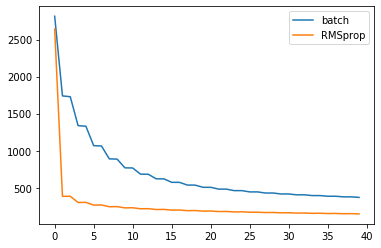

In [17]:
main()